# **Part 1: Emotion Recognition**

# **1.Python Libraries**

In [4]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow import keras
import cv2
import os
import glob
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import Callback
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, accuracy_score

# **2.Connect to Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **3.Unzip Data**

In [3]:
!unzip /content/drive/MyDrive/fer2013.csv.zip

Archive:  /content/drive/MyDrive/fer2013.csv.zip
  inflating: fer2013.csv             


# **4.Read Data**

In [4]:
Data_set = pd.read_csv('/content/fer2013.csv') #path
print(Data_set.shape)
Data_set.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

# **5.Exploratory Data Analysis**

categories in data

In [5]:
Data_set.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

The dictionary associates labels with emotions. 

In [6]:
emotion_label_to_text = {0:'anger',
                         1:'disgust',
                         2:'fear', 
                         3:'happiness',
                         4: 'sadness', 
                         5: 'surprise', 
                         6: 'neutral'}

number of images in each category

In [7]:
Data_set.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

visualisation of the number of images in each category before any preprocessing

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


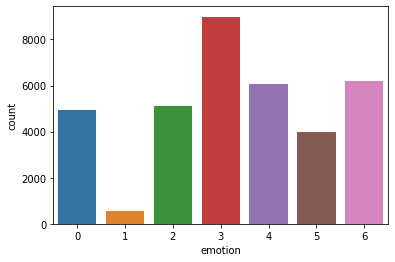

In [8]:
sns.countplot(Data_set.emotion)
pyplot.show()

**Data agumentation**

function to augment iamges

In [12]:
def augment_pixels(px, shape = 48):
    image = np.array(px.split(' ')).reshape(shape, shape).astype('float32')
    image = tf.image.random_flip_left_right(image.reshape(shape,shape,1))
    
    image = tf.image.resize_with_crop_or_pad(image, shape + 12, shape + 12) 
    
    image = tf.image.random_crop(image, size=[shape, shape, 1])
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.clip_by_value(image, 0, 255)
    augmented = image.numpy().reshape(shape,shape)
    str_augmented = ' '.join(augmented.reshape(shape*shape).astype('int').astype(str))
    return str_augmented

valcounts = Data_set.emotion.value_counts()
valcounts_diff = valcounts[valcounts.idxmax()] - valcounts
for emotion_idx, aug_count in valcounts_diff.iteritems():
    sampled = Data_set.query("emotion==@emotion_idx").sample(aug_count, replace=True)
    sampled['pixels'] = sampled.pixels.apply(augment_pixels)
    Data_set = pd.concat([Data_set, sampled])
    print(emotion_idx, aug_count)

3 0
6 2791
4 2912
2 3868
0 4036
5 4987
1 8442


visualisation of the number of images in each category after augmentation

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


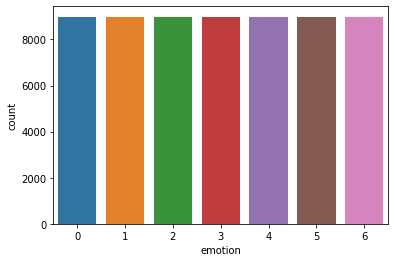

In [13]:
sns.countplot(Data_set.emotion)
pyplot.show()

sample of images

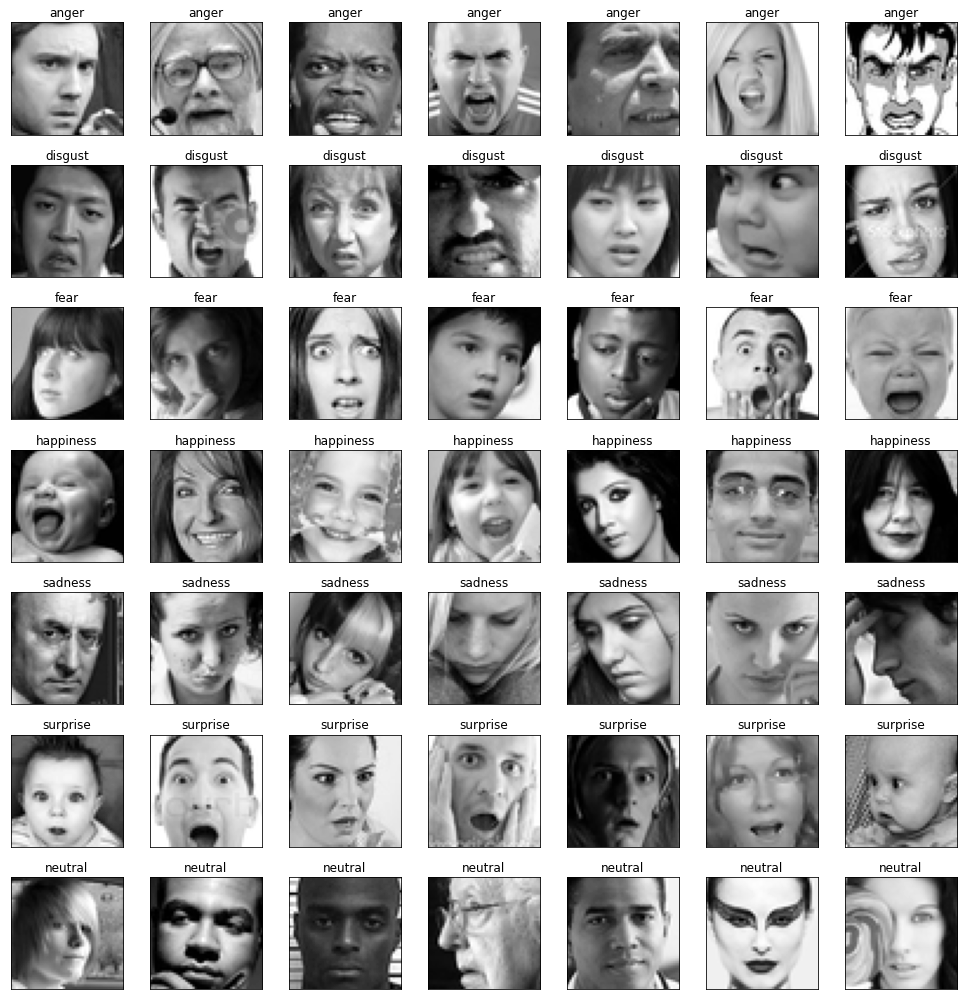

In [14]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(Data_set.emotion.unique()):
    for j in range(7):
        px = Data_set[Data_set.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

# **6.Data Preprocessing**

In [15]:
img_array = Data_set.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [16]:
img_array.shape

(62923, 48, 48, 1)

In [17]:
le = LabelEncoder()
img_labels = le.fit_transform(Data_set.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(62923, 7)

split data to training and validation

In [18]:
x_train, x_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)

Data shape

In [19]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((56630, 48, 48, 1), (6293, 48, 48, 1), (56630, 7), (6293, 7))

Normalize pixels

In [20]:
x_train = x_train / 255.
x_valid = x_valid / 255.

In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(x_train)

# **7.Build DCNN Model**

In [23]:
def build_model(optim):
    model = Sequential()

    model.add(Conv2D(filters=64,kernel_size=(5,5),input_shape=(48, 48, 1),activation='elu',padding='same',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64,kernel_size=(5,5),activation='elu',padding='same',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(filters=128,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256,kernel_size=(3,3),activation='elu',padding='same',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
        
    model.add(Dense(128,activation='elu',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    
    model.add(Dropout(0.6))
    
    model.add(Dense(7,activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    model.summary()
    
    return model

**custom compile**

In [24]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

**train model**

In [25]:
batch_size = 32 
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

model = build_model(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_valid, y_valid),
    steps_per_epoch=len(x_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

<ipython-input-25-1f0f2970c7c7>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
1769/1769 [==============================] - 68s 33ms/step - loss: 1.9406 - accuracy: 0.2657 - val_loss: 1.5390 - val_accuracy: 0.4211 - lr: 0.0010
Epoch 2/100
1769/1769 [==============================] - 59s 34ms/step - loss: 1.5416 - accuracy: 0.4057 - val_loss: 1.4111 - val_accuracy: 0.4592 - lr: 0.0010
Epoch 3/100
1769/1769 [==============================] - 59s 33ms/step - loss: 1.3765 - accuracy: 0.4769 - val_loss: 1.1437 - val_accuracy: 0.5652 - lr: 0.0010
Epoch 4/100
1769/1769 [==============================] - 57s 32ms/step - loss: 1.2874 - accuracy: 0.5124 - val_loss: 1.1429 - val_accuracy: 0.5749 - lr: 0.0010
Epoch 5/100
1769/1769 [==============================] - 58s 33ms/step - loss: 1.2194 - accuracy: 0.5428 - val_loss: 1.1039 - val_accuracy: 0.5943 - lr: 0.0010
Epoch 6/100
1769/1769 [==============================] - 60s 34ms/step - loss: 1.1723 - accuracy: 0.5603 - val_loss: 1.0199 - val_accuracy: 0.6170 - lr: 0.0010
Epoch 7/100
1769/1769 [=================

**training curves**

Text(0.5, 0, 'epoch')

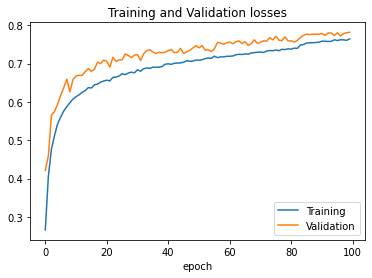

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

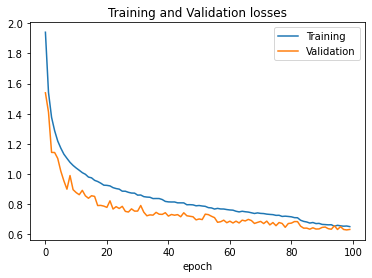

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')

**Evaluate model**

In [48]:
loss_acc_train = model.evaluate(x= x_train, y=y_train)
loss_acc_validation = model.evaluate(x= x_valid, y=y_valid)

197/197 [==============================] - 2s 9ms/step - loss: 0.6328 - accuracy: 0.7820


In [49]:
pd.DataFrame({'train_loss': loss_acc_train[0], 'train_accuracy': loss_acc_train[1]}, index=[''])

,train_loss,train_accuracy
,0.427637,0.84653


In [50]:
pd.DataFrame({'validation_loss': loss_acc_validation[0], 'validation_accuracy': loss_acc_validation[1]}, index=[''])

,validation_loss,validation_accuracy
,0.632792,0.78198


In [36]:
y_pred = np.argmax(model.predict(x_valid), axis=1)

197/197 [==============================] - 3s 8ms/step


In [53]:
print(confusion_matrix(np.argmax(y_valid, axis=1),y_pred))
print()
accu = accuracy_score(np.argmax(y_valid, axis=1),y_pred)*100
pd.DataFrame({'accuracy': accu} , index=[''])

[[654   9  68  16  63  27  62]
 [  2 897   0   0   0   0   0]
 [ 86   0 547  14 116  74  62]
 [ 16   0  14 781  13  20  55]
 [ 89   1 110  20 518  14 147]
 [ 13   1  37  12   2 824  10]
 [ 50   0  41  37  60  11 700]]



,accuracy
,78.197998


# **Finally Save The Model**

In [1]:
model.save('/content/drive/MyDrive/emotionRecognition.h5')

# **Part 2: Face Detection**

**Show image**

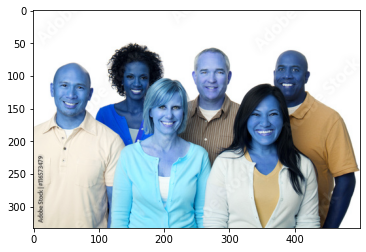

In [5]:
img = cv2.imread("/content/image.jpg")
plt.imshow(img)

 **function to detect faces in image**

**Use Open cv2 library to fetect faces**

In [6]:
def face_detection(path):
    #read image
    image = cv2.imread(path)
    #conver image to GRAY
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.075,
        minNeighbors=5,
        minSize=(48, 48)
    )

    #draw boxes around faces
    for (x,y,w,h) in faces:
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = image[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex,ey,ew,eh) in eyes:
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

    print("[INFO] Found {0} Faces!".format(len(faces)))

    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0,0,255), 2)
    return image

**show image after detect face**

[INFO] Found 6 Faces!


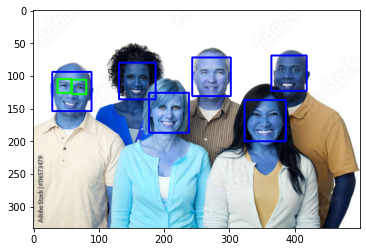

In [8]:
path = "/content/image.jpg"
new_img = face_detection(path)
plt.imshow(new_img)